In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

from src.similarity import CosineSimilarity, PearsonSimilarity
from src.tree import TreeNode

from diffusion_map import DiffusionMap


#### Data Loading

In [2]:
file_path = '/Users/haiy/git/quests/questionnaire_matlab_legacy/examples/MMPI2_Depolarized.mat'
d = sp.io.loadmat(file_path)
data = d['matrix']
data_cols = d['points_dat']
data_rows = d['sensors_dat']
original_people_scores = d['original_people_scores']

#### Data preprocessing

In [3]:
vals,names=data_cols.squeeze().tolist()
names = [str(n[0]) for n in names.flatten().tolist()]
df_cols = pd.DataFrame(vals.T,columns=names)

df_rows = pd.DataFrame([[str(i[0])] for i in data_rows.squeeze().tolist()[0].flatten()],columns=['question'])

In [4]:
# make data is binary
# data[data==0] = -1


#### data is presented as follows

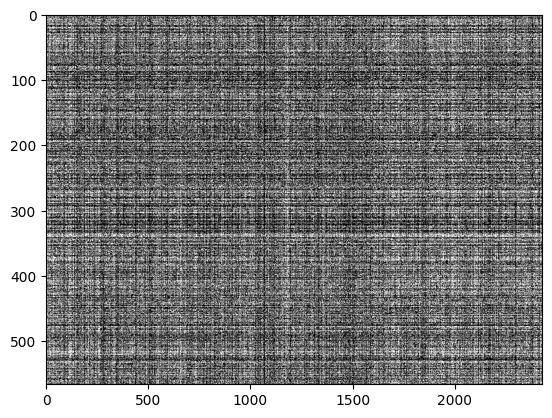

In [5]:
plt.imshow(data,cmap='gray',aspect='auto',vmin=0,vmax=1)
plt.show()

#### initial affinity for columns

In [6]:
similarity = CosineSimilarity(threshold=0)(data.T)
embedding = DiffusionMap(similarity,n_dim=10).transform(t=1)

#### build the initial binary trees

In [7]:
from src.tree import build_binary_tree_by_median_split, build_binary_tree_by_kmeans

In [8]:
root = build_binary_tree_by_median_split(similarity,min_size=10,max_depth=5)

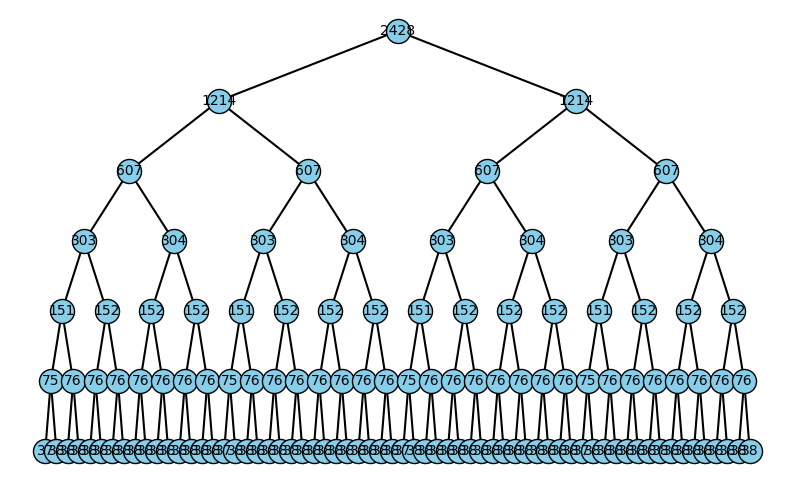

<Axes: >

: 

In [ ]:
from src.utils.plot_binary_tree import plot_binary_tree

plot_binary_tree(root)

In [ ]:
from src.utils.scatter_3d import scatter_3d

scatter_3d(embedding,KMeans(n_clusters=2).fit(embedding).labels_)

there is an obvious outlier that gets singled out at the level 1. 

-----------

#### dual embedding of rows

In [ ]:
rows_dual_embedding = root.compute_coef_and_dual_embedding(data,axis=1)

#### compute the dual geometry on the rows

In [ ]:
from src.similarity import Exponential_Cityblock_Similarity

In [ ]:
row_sim = Exponential_Cityblock_Similarity()(rows_dual_embedding)

In [ ]:
row_emb = DiffusionMap(row_sim,n_dim=6).transform(t=1)

In [ ]:
scatter_3d(row_emb,labels=KMeans(n_clusters=2).fit(row_emb).labels_)

#### A proper run of the questionnaire algorithm 

In [ ]:
n_eigs = 8
iter_dual_geom = 3

In [ ]:
row_iters = []
col_iters = []


# build initial col tree
col_sim = CosineSimilarity(threshold=0)(data.T)
col_emb = DiffusionMap(col_sim,n_dim=n_eigs).transform(t=1)
col_tree = build_binary_tree(col_emb)

col_iters.append((col_sim,col_emb,col_tree))

# begin dual geometry iterations 
for i in range(iter_dual_geom):
    
    # update the rows
    _,_,col_tree = col_iters[-1]
    
    # compute the EMD embedding from the row trees
    row_emd = col_tree.compute_coef_and_dual_embedding(data,axis=1)
    row_sim = Exponential_Cityblock_Similarity()(row_emd)
    row_emb = DiffusionMap(row_sim,n_dim=n_eigs).transform(t=1)
    row_tree = build_binary_tree(row_emb)
    
    row_iters.append((row_sim,row_emb,row_tree))
    
    
    # update the cols
    _,_,row_tree = row_iters[-1]
    col_emd = row_tree.compute_coef_and_dual_embedding(data,axis=0).T
    col_sim = Exponential_Cityblock_Similarity()(col_emd)
    col_emb = DiffusionMap(col_sim,n_dim=n_eigs).transform(t=1)
    col_tree = build_binary_tree(col_emb)    
    col_iters.append((col_sim,col_emb,col_tree))

#### make the plots for the row trees

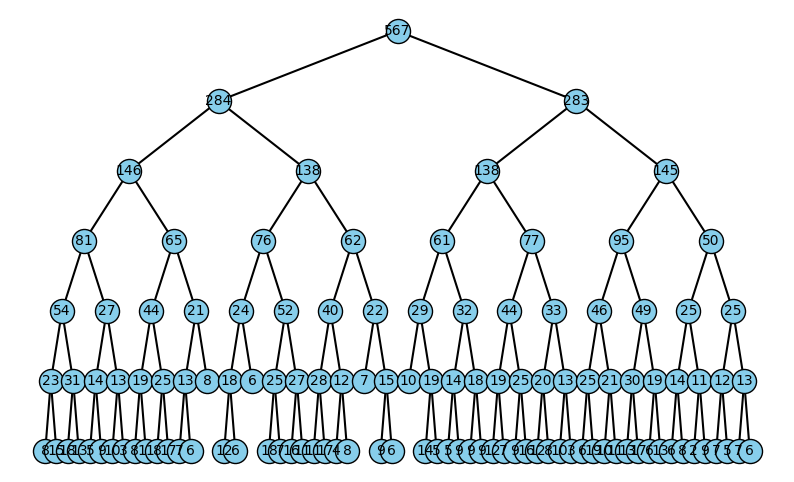

<Axes: >

In [ ]:
plot_binary_tree(row_tree)

In [ ]:
row_sim,row_emb,row_tree = row_iters[-1]
levels = [node.data for node in row_tree.bfs() if node.distance2root()==3 or node.distance2root()<3 and node.depth()==0]
color = np.zeros(data.shape[0])
for i,level in enumerate(levels):
    color[level] = i

scatter_3d(row_emb,labels=color,marker_size=3,title='Row Embedding')

In [ ]:
_,col_emb,col_tree = col_iters[3]
levels = [node.data for node in col_tree.bfs() if node.distance2root()==3 or node.distance2root()<3 and node.depth()==0]
color = np.zeros(data.shape[1])

for i,level in enumerate(levels):
    color[level] = i

scatter_3d(col_emb,labels=color,marker_size=3,title='Col Embedding')

------------------

#### prediction tasks

In [ ]:
# Augmenting the columns